In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns

from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [30]:
df = pd.read_csv('/Users/Sam/Downloads/data_set_hackathon.csv')

In [31]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/Users/Sam/Downloads/data_set_hackathon.csv')

# Remove rows where 'value' is less than or equal to 0
df = df[df['value'] > 0]

# Remove rows where 'items' column has the value '\N'
df = df[df['items'] != r'\N']

# Display the first few rows of the cleaned dataset
print(df.head())


   order_date requested_delivery_date Customer Country Code Product Code  \
0  13.07.2009              28.01.2010                    RU    L10705000   
1  15.07.2009              24.03.2010                    RU    L10705000   
2  16.07.2009              04.02.2010                    RU    L10705000   
3  17.07.2009              04.02.2010                    RU    L10705000   
4  21.07.2009              01.02.2010                    RU    L10705000   

                   Description order_type  Customer Order Code     value Curr  \
0  Parka Outdoor Lifestyle STD         VO           3200435553   2337.00  RUB   
1  Parka Outdoor Lifestyle STD         VO           3200435694  10160.25  RUB   
2  Parka Outdoor Lifestyle STD         VO           3200435741   2992.50  RUB   
3  Parka Outdoor Lifestyle STD         VO           3200435907   4061.25  RUB   
4  Parka Outdoor Lifestyle STD         VO           3200435963   2208.75  RUB   

  items   Route  
0     6  RU0001  
1    23  RU0001  
2 

In [32]:
#1.	How many distinct orders are received in each month?

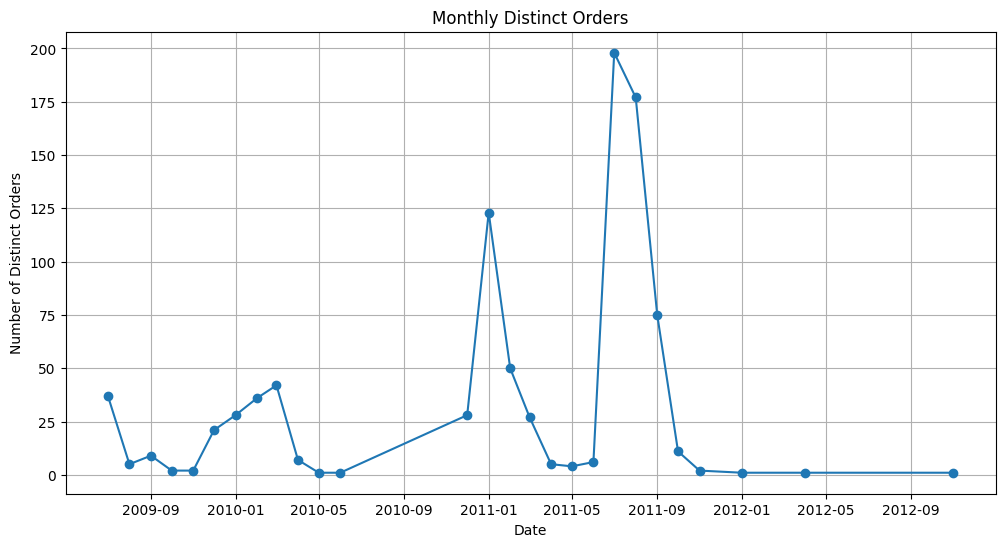

ADF Statistic: -3.59241149910783
p-value: 0.005907771862762453
                                      SARIMAX Results                                      
Dep. Variable:                 Customer Order Code   No. Observations:                   27
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                   1.050
Date:                             Sun, 08 Dec 2024   AIC                              5.900
Time:                                     03:34:07   BIC                             -2.100
Sample:                                          0   HQIC                              -inf
                                              - 27                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5357      0.006    -91.435

/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning: divide by zero encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/Users/sam/Library/Python/3.

<Figure size 1500x1000 with 0 Axes>

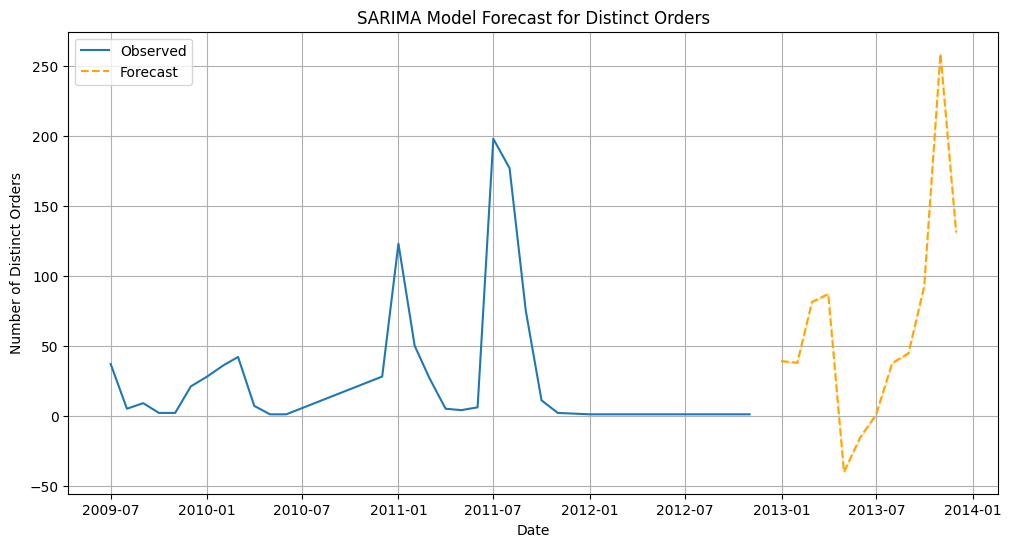

In [33]:
# Parse dates and extract month and year
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')

# Group by month and count distinct Customer Order Codes
df['Year-Month'] = df['order_date'].dt.to_period('M')
monthly_orders = df.groupby('Year-Month')['Customer Order Code'].nunique().reset_index()
monthly_orders['Year-Month'] = monthly_orders['Year-Month'].astype(str)

# Convert to time series
monthly_orders_ts = monthly_orders.set_index('Year-Month')['Customer Order Code']

# Ensure the index is datetime for SARIMA
monthly_orders_ts.index = pd.to_datetime(monthly_orders_ts.index)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(monthly_orders_ts, marker='o')
plt.title('Monthly Distinct Orders')
plt.xlabel('Date')
plt.ylabel('Number of Distinct Orders')
plt.grid(True)
plt.show()

# Check stationarity
adf_test = adfuller(monthly_orders_ts)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

# Differencing if not stationary
if adf_test[1] > 0.05:
    monthly_orders_diff = monthly_orders_ts.diff().dropna()
else:
    monthly_orders_diff = monthly_orders_ts

# Fit SARIMA model (simplified parameters to avoid overfitting)
sarima_model = SARIMAX(monthly_orders_ts, 
                       order=(1, 1, 1), 
                       seasonal_order=(1, 1, 0, 12),  # Simplified seasonal order
                       enforce_stationarity=False, 
                       enforce_invertibility=False)
sarima_results = sarima_model.fit(disp=False)

# Model summary
print(sarima_results.summary())

# Plot diagnostics (may warn if too few observations)
try:
    sarima_results.plot_diagnostics(figsize=(15, 10))
    plt.show()
except ValueError as e:
    print("Diagnostics plot skipped due to insufficient data:", e)

# Forecast future values
forecast_steps = 12  # Forecasting 12 months ahead
forecast = sarima_results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=monthly_orders_ts.index[-1] + pd.DateOffset(months=1), 
                               periods=forecast_steps, 
                               freq='M')
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_orders_ts, label='Observed')
plt.plot(forecast_index, forecast_values, label='Forecast', linestyle='--', color='orange')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.2)
plt.title('SARIMA Model Forecast for Distinct Orders')
plt.xlabel('Date')
plt.ylabel('Number of Distinct Orders')
plt.legend()
plt.grid(True)
plt.show()



In [34]:
#2.	Which items are demanded (i.e., classification-choice model)?

In [35]:
# Parse dates and extract seasons
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')
df['Season'] = df['order_date'].dt.month % 12 // 3 + 1  # Divide months into 4 seasons: 1-3, 4-6, 7-9, 10-12

# Encode categorical variables
label_encoder = LabelEncoder()
df['Customer Country Code'] = label_encoder.fit_transform(df['Customer Country Code'])
df['Route'] = label_encoder.fit_transform(df['Route'])
df['Product Code'] = label_encoder.fit_transform(df['Product Code'])

# Select features and target
features = ['Season', 'Customer Country Code', 'value', 'Route']
target = 'Product Code'

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)


Confusion Matrix:
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 3]
 [0 0 0 ... 0 1 3]
 [0 0 0 ... 4 2 1]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         3
           6       0.07      0.20      0.11         5
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00         3
          10       0.11      0.11      0.11         9
          11       0.00      0.00      0.00         5
          12       0.14      0.11      0.12         9
          13       0.14      0.17      0.15         6
          14       1.00    

In [36]:
#3.	What is the quantity demanded for each item in these orders?

Empirical Quantiles for Quantity Demanded:
              25th Percentile  50th Percentile  75th Percentile
Product Code                                                   
0                        5.00              6.0             8.00
1                        6.00              9.0            13.05
2                        5.00              6.0            10.00
3                        5.00              7.0            10.00
4                        6.00              9.0            15.80
5                        5.00              8.5            13.10
6                        5.00              7.5             8.00
7                        3.95              6.5             8.25
8                        3.00              5.0            10.00
9                        1.00              2.0             5.05
10                       2.45              4.0             6.00
11                       3.95              5.0            11.00
12                       2.00              4.0             8.

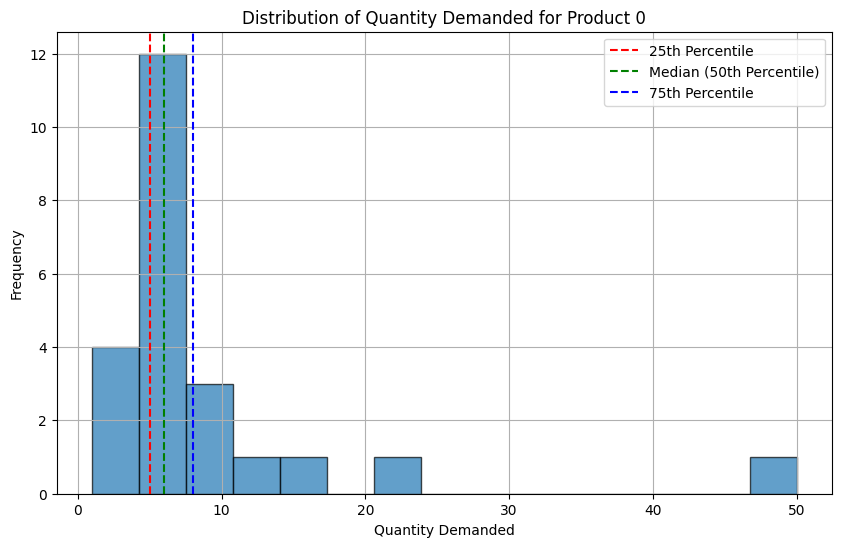

In [37]:
import pandas as pd
from scipy.stats.mstats import mquantiles
import matplotlib.pyplot as plt


# Ensure 'items' column is numeric for quantile calculations
df['items'] = pd.to_numeric(df['items'], errors='coerce')

# Drop rows with NaN in 'items'
df = df.dropna(subset=['items'])

# Group data by Product Code and compute empirical quantiles for quantity demanded
quantile_results = {}

# Define quantile levels
quantile_levels = [0.25, 0.5, 0.75]  # 25th, 50th (median), and 75th percentiles

# Calculate quantiles for each product
for product, group in df.groupby('Product Code'):
    quantiles = mquantiles(group['items'], prob=quantile_levels)
    quantile_results[product] = quantiles

# Convert results to DataFrame for better readability
quantile_df = pd.DataFrame(quantile_results, index=['25th Percentile', '50th Percentile', '75th Percentile']).T
quantile_df.index.name = 'Product Code'

# Display quantile results
print("Empirical Quantiles for Quantity Demanded:")
print(quantile_df)


# Plotting example for a single product (optional visualization)

# Choose a specific Product Code to visualize
example_product = df['Product Code'].unique()[0]
example_data = df[df['Product Code'] == example_product]['items']

plt.figure(figsize=(10, 6))
plt.hist(example_data, bins=15, edgecolor='k', alpha=0.7)
plt.axvline(quantile_results[example_product][0], color='r', linestyle='--', label='25th Percentile')
plt.axvline(quantile_results[example_product][1], color='g', linestyle='--', label='Median (50th Percentile)')
plt.axvline(quantile_results[example_product][2], color='b', linestyle='--', label='75th Percentile')
plt.title(f'Distribution of Quantity Demanded for Product {example_product}')
plt.xlabel('Quantity Demanded')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
#4.	What is the demand lead time of these orders (i.e., time elapsed from the instant 
# when an order is received until its delivery)?

Empirical Quantiles for Demand Lead Time:
         25th Percentile  50th Percentile  75th Percentile
Overall            195.0            217.0            251.0


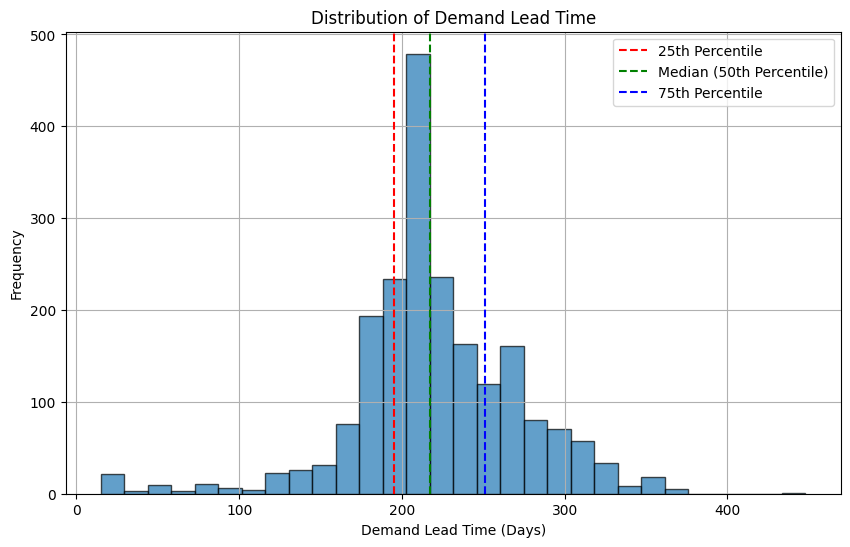

In [39]:
import pandas as pd
from scipy.stats.mstats import mquantiles
import matplotlib.pyplot as plt


# Ensure dates are in datetime format
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')
df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'], format='%d.%m.%Y')

# Calculate demand lead time (in days)
df['demand_lead_time'] = (df['requested_delivery_date'] - df['order_date']).dt.days

# Drop rows with invalid or negative lead time
df = df[df['demand_lead_time'] >= 0]

# Group data and compute empirical quantiles for demand lead time
lead_time_quantiles = {}

# Define quantile levels
quantile_levels = [0.25, 0.5, 0.75]  # 25th, 50th (median), and 75th percentiles

# Calculate quantiles
quantiles = mquantiles(df['demand_lead_time'], prob=quantile_levels)
lead_time_quantiles['Overall'] = quantiles

# Convert results to DataFrame for better readability
quantile_df = pd.DataFrame(lead_time_quantiles, index=['25th Percentile', '50th Percentile', '75th Percentile']).T

# Display quantile results
print("Empirical Quantiles for Demand Lead Time:")
print(quantile_df)



# Visualization of lead time distribution and quantiles
plt.figure(figsize=(10, 6))
plt.hist(df['demand_lead_time'], bins=30, edgecolor='k', alpha=0.7)
plt.axvline(quantiles[0], color='r', linestyle='--', label='25th Percentile')
plt.axvline(quantiles[1], color='g', linestyle='--', label='Median (50th Percentile)')
plt.axvline(quantiles[2], color='b', linestyle='--', label='75th Percentile')
plt.title('Distribution of Demand Lead Time')
plt.xlabel('Demand Lead Time (Days)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [40]:
#5After you characterize each uncertainty by predictive models, classification methods, 
# or empirically, you can apply Monte Carlo simulation to consolidate them into total demand. After simulation, 
# you must analyze simulated data and distinguish advance demand from urgent demand.

/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index w

Average Results Across Simulations:
advance    205.0
urgent       0.0
dtype: float64


/Users/sam/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/sam/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/sam/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/sam/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/sam/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


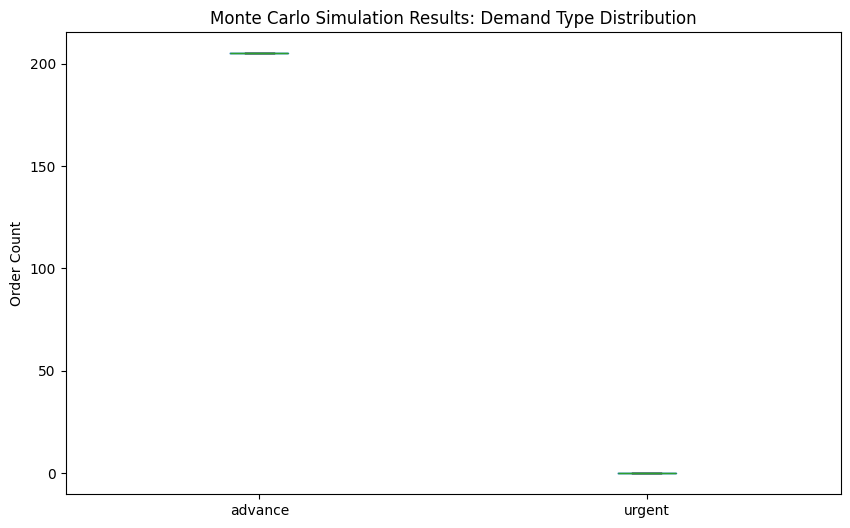

In [41]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestClassifier
from scipy.stats.mstats import mquantiles
import matplotlib.pyplot as plt


# Ensure dates are in datetime format
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')
df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'], format='%d.%m.%Y')

# Calculate demand lead time (in days)
df['demand_lead_time'] = (df['requested_delivery_date'] - df['order_date']).dt.days
df = df[df['demand_lead_time'] >= 0]  # Remove invalid lead times

# Define SARIMA model (from question 1)
df['Year-Month'] = df['order_date'].dt.to_period('M')
monthly_orders = df.groupby('Year-Month')['Customer Order Code'].nunique().reset_index()
monthly_orders['Year-Month'] = monthly_orders['Year-Month'].astype(str)
monthly_orders_ts = monthly_orders.set_index('Year-Month')['Customer Order Code']
monthly_orders_ts.index = pd.to_datetime(monthly_orders_ts.index)

sarima_model = SARIMAX(monthly_orders_ts, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))
sarima_results = sarima_model.fit(disp=False)

# Train Random Forest classifier (from question 2)
df['Season'] = df['order_date'].dt.month % 12 // 3 + 1
features = ['Season', 'Customer Country Code', 'value', 'Route']
df['Customer Country Code'] = df['Customer Country Code'].astype('category').cat.codes
df['Route'] = df['Route'].astype('category').cat.codes
df['Product Code'] = df['Product Code'].astype('category').cat.codes
X = df[features]
y = df['Product Code']
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Define empirical quantiles (from questions 3 and 4)
df['items'] = pd.to_numeric(df['items'], errors='coerce')
df = df.dropna(subset=['items'])
quantity_quantiles = mquantiles(df['items'], prob=[0.25, 0.5, 0.75])
lead_time_quantiles = mquantiles(df['demand_lead_time'], prob=[0.25, 0.5, 0.75])

# Monte Carlo Simulation
num_simulations = 10
simulation_results = []

for sim in range(num_simulations):
    # Simulate monthly order counts using SARIMA
    forecast_steps = 12
    sarima_forecast = sarima_results.get_forecast(steps=forecast_steps)
    simulated_monthly_orders = sarima_forecast.predicted_mean.astype(int)

    simulated_data = []

    for month, orders in enumerate(simulated_monthly_orders, start=1):
        for _ in range(orders):
            # Simulate product choice using Random Forest
            simulated_features = np.array([month % 4 + 1, 0, 100, 0]).reshape(1, -4)  # Example features
            product = rf_model.predict(simulated_features)[0]
            
            # Simulate quantity and lead time
            quantity = np.random.choice(quantity_quantiles)
            lead_time = np.random.choice(lead_time_quantiles)

            # Calculate simulated delivery date
            order_date = pd.Timestamp(f'2024-{month:02d}-01')
            delivery_date = order_date + pd.to_timedelta(lead_time, unit='D')

            # Determine demand type
            demand_type = 'urgent' if (delivery_date <= order_date + pd.DateOffset(months=5)) else 'advance'
            
            simulated_data.append({
                'Order Date': order_date,
                'Product': product,
                'Quantity': quantity,
                'Lead Time': lead_time,
                'Delivery Date': delivery_date,
                'Demand Type': demand_type
            })

    # Aggregate results for this simulation
    simulated_df = pd.DataFrame(simulated_data)
    demand_counts = simulated_df['Demand Type'].value_counts().reindex(['advance', 'urgent'], fill_value=0).to_dict()
    simulation_results.append(demand_counts)

# Combine simulation results
simulation_df = pd.DataFrame(simulation_results)

# Display average results across simulations
average_results = simulation_df.mean()
print("Average Results Across Simulations:")
print(average_results)



# Visualization
plt.figure(figsize=(10, 6))
simulation_df.boxplot(column=['advance', 'urgent'], grid=False)
plt.title('Monte Carlo Simulation Results: Demand Type Distribution')
plt.ylabel('Order Count')
plt.show()


/var/folders/t8/98kc315d6592z5nmcq76rt9h0000gn/T/ipykernel_8194/1970686085.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Year-Month'] = train_df['order_date'].dt.to_period('M')
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sam/Library/Python/3.9/li

Actual Advance Demand (Test Set): [0, 1, 1]
Simulated Advance Demand: [1, 1, 4]
MAPE: 150119987579016640.00%


/Users/sam/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


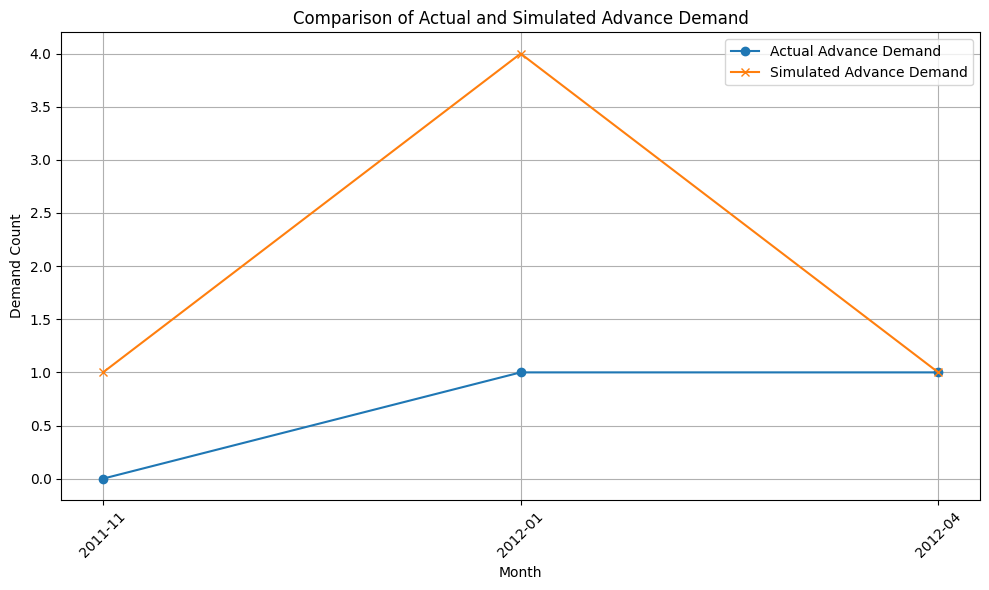

In [42]:
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import numpy as np
from datetime import timedelta



# Ensure dates are in datetime format
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')
df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'], format='%d.%m.%Y')

# Calculate demand lead time (in days)
df['demand_lead_time'] = (df['requested_delivery_date'] - df['order_date']).dt.days
df = df[df['demand_lead_time'] >= 0]  # Remove invalid lead times

# Split data into training and testing sets
last_five_months_start = df['order_date'].max() - pd.DateOffset(months=5)
test_df = df[df['order_date'] >= last_five_months_start]
train_df = df[df['order_date'] < last_five_months_start]

# Define SARIMA model (train only on train_df)
train_df['Year-Month'] = train_df['order_date'].dt.to_period('M')
monthly_orders = train_df.groupby('Year-Month')['Customer Order Code'].nunique().reset_index()
monthly_orders['Year-Month'] = monthly_orders['Year-Month'].astype(str)
monthly_orders_ts = monthly_orders.set_index('Year-Month')['Customer Order Code']
monthly_orders_ts.index = pd.to_datetime(monthly_orders_ts.index)

sarima_model = SARIMAX(monthly_orders_ts, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))
sarima_results = sarima_model.fit(disp=False)

# Simulate demand using Monte Carlo for test data
simulated_advance_demand = []

for month in test_df['order_date'].dt.to_period('M').unique():
    # Simulate advance demand for the month
    simulated_month_orders = []
    for _, row in test_df[test_df['order_date'].dt.to_period('M') == month].iterrows():
        lead_time = np.random.choice(mquantiles(train_df['demand_lead_time'], prob=[0.25, 0.5, 0.75]))
        simulated_delivery_date = row['order_date'] + timedelta(days=int(lead_time))
        if simulated_delivery_date > row['requested_delivery_date']:
            simulated_month_orders.append('advance')
    simulated_advance_demand.append(len(simulated_month_orders))

# Actual advance demand in test set
actual_advance_demand = []
for month in test_df['order_date'].dt.to_period('M').unique():
    actual_month_orders = test_df[test_df['order_date'].dt.to_period('M') == month]
    advance_orders = actual_month_orders[actual_month_orders['demand_lead_time'] > 150]  # Assuming 150 days for advance
    actual_advance_demand.append(len(advance_orders))

# Calculate MAPE
mape = mean_absolute_percentage_error(actual_advance_demand, simulated_advance_demand)

print("Actual Advance Demand (Test Set):", actual_advance_demand)
print("Simulated Advance Demand:", simulated_advance_demand)
print(f"MAPE: {mape:.2%}")


import matplotlib.pyplot as plt



# Prepare data for visualization and ensure chronological order of months
results = pd.DataFrame({
    'Month': [str(period) for period in test_df['order_date'].dt.to_period('M').unique()],
    'Actual Advance Demand': actual_advance_demand,
    'Simulated Advance Demand': simulated_advance_demand
})

# Sort results by Month
results['Month'] = pd.to_datetime(results['Month'])
results = results.sort_values(by='Month')

# Convert Month back to string for consistent plotting
results['Month'] = results['Month'].dt.strftime('%Y-%m')

# Visualize the comparison
plt.figure(figsize=(10, 6))
plt.plot(results['Month'], results['Actual Advance Demand'], label='Actual Advance Demand', marker='o')
plt.plot(results['Month'], results['Simulated Advance Demand'], label='Simulated Advance Demand', marker='x')
plt.title('Comparison of Actual and Simulated Advance Demand')
plt.xlabel('Month')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.ylabel('Demand Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




图中 **y轴的 Demand Count** 是每个月的 **Advance Demand** 的订单数量，分别对应：

1. **Actual Advance Demand**：
   - 测试数据集中，真实的 `Advance Demand` 的订单数量。
   - 按照规则：订单的 `demand_lead_time` 大于 150 天（5 个月）或 `simulated_delivery_date` 超过 `requested_delivery_date`。

2. **Simulated Advance Demand**：
   - Monte Carlo 模拟中计算的 `Advance Demand` 数量。
   - 根据每个月的订单，结合模拟的 `lead time`，判断是否属于 `Advance Demand`。

**解释**：
- **Actual** 和 **Simulated** 分别反映了测试集中的真实 `Advance Demand` 和通过模拟预测的 `Advance Demand`。
- y轴的值是按月累计的订单数。

如果你需要进一步调整规则或分析，请告诉我！


In [43]:
#6 XYZ can reduce the production lead time to two months so that inventory decisions are based on demand forecasts with two-month horizon. 
# What is the impact of reducing the lead time on the forecast accuracy?

Actual Advance Demand (Test Set - 2 Months): [1]
Simulated Advance Demand (2 Months): [1]
MAPE (2-Month Horizon): 0.00%


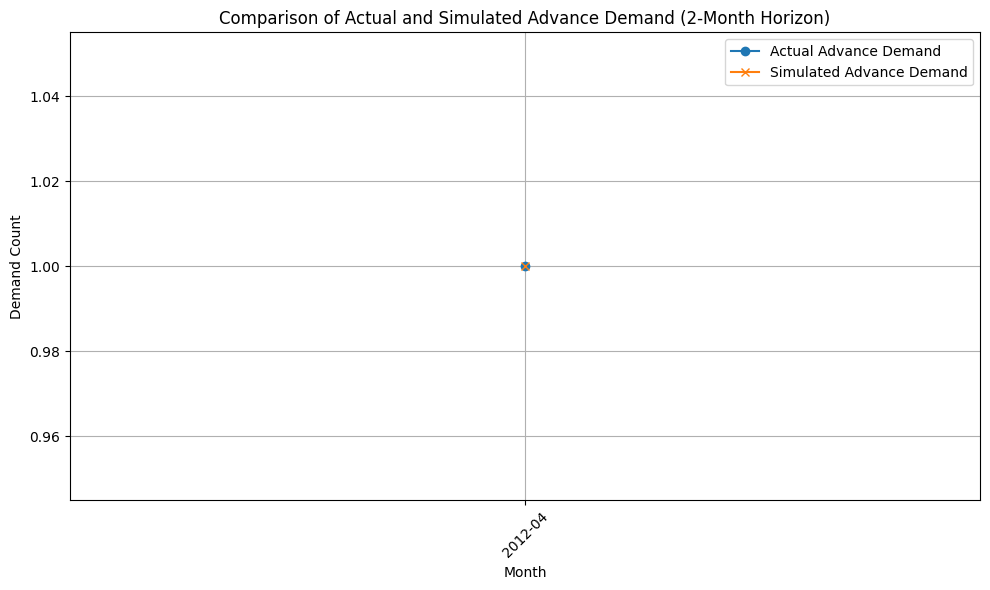

In [44]:
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt



# Ensure dates are in datetime format
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')
df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'], format='%d.%m.%Y')

# Calculate demand lead time (in days)
df['demand_lead_time'] = (df['requested_delivery_date'] - df['order_date']).dt.days
df = df[df['demand_lead_time'] >= 0]  # Remove invalid lead times





# Adjust test data to ensure two months are included
test_df = df[df['order_date'] >= df['order_date'].max() - pd.DateOffset(months=2)]
train_df = df[df['order_date'] < df['order_date'].max() - pd.DateOffset(months=2)]

# Simulate demand using Monte Carlo for test data with 2-month horizon
simulated_advance_demand = []

for month in test_df['order_date'].dt.to_period('M').unique():
    simulated_month_orders = []
    for _, row in test_df[test_df['order_date'].dt.to_period('M') == month].iterrows():
        lead_time = np.random.choice(mquantiles(train_df['demand_lead_time'], prob=[0.25, 0.5, 0.75]))
        simulated_delivery_date = row['order_date'] + timedelta(days=int(lead_time))
        if simulated_delivery_date > row['order_date'] + timedelta(days=60):  # Advance demand beyond 2 months
            simulated_month_orders.append('advance')
    simulated_advance_demand.append(len(simulated_month_orders))

# Actual advance demand in test set (2-month horizon)
actual_advance_demand = []
for month in test_df['order_date'].dt.to_period('M').unique():
    actual_month_orders = test_df[test_df['order_date'].dt.to_period('M') == month]
    advance_orders = actual_month_orders[actual_month_orders['demand_lead_time'] > 60]  # 60 days = 2 months
    actual_advance_demand.append(len(advance_orders))

# Calculate MAPE for 2-month horizon
mape = mean_absolute_percentage_error(actual_advance_demand, simulated_advance_demand)

print("Actual Advance Demand (Test Set - 2 Months):", actual_advance_demand)
print("Simulated Advance Demand (2 Months):", simulated_advance_demand)
print(f"MAPE (2-Month Horizon): {mape:.2%}")

# Prepare data for visualization and ensure chronological order
results = pd.DataFrame({
    'Month': [str(period) for period in test_df['order_date'].dt.to_period('M').unique()],
    'Actual Advance Demand': actual_advance_demand,
    'Simulated Advance Demand': simulated_advance_demand
})
results['Month'] = pd.to_datetime(results['Month'])  # Convert to datetime for sorting
results = results.sort_values(by='Month')  # Sort by Month
results['Month'] = results['Month'].dt.strftime('%Y-%m')  # Format back to string for plotting

# Visualize the comparison for 2-month horizon
plt.figure(figsize=(10, 6))
plt.plot(results['Month'], results['Actual Advance Demand'], label='Actual Advance Demand', marker='o')
plt.plot(results['Month'], results['Simulated Advance Demand'], label='Simulated Advance Demand', marker='x')
plt.title('Comparison of Actual and Simulated Advance Demand (2-Month Horizon)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.ylabel('Demand Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()














